# Tweets semantic analysis - Trump vs. Clinton #

That's the first attempt I am doing in order to to visualize word vectos along with t-SNE. 

I don't know yet if it's the best tool yet even if it scales high-dimensional vocabulary feature vectors to a compressed dimension such as the 2-dimensional x,y coordinate pairs. 

The method hereby presented it's a slight copy/paste of other found online and github - here few references: https://www.kaggle.com/jihyeseo/visualizing-word-vectors-with-t-sne

The same steps have been reproduced: 

1. __Import Dataset tweets.csv__
2. __Clean the Data__
3. __Build a corpus__
4. __Train a Word2Vec Model__
5. __Visualize t-SNE representations of the most common words__
6. __Further interrelations__

In [44]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE 

import gzip
import logging
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import re 
import sys

import matplotlib

In [45]:
import matplotlib.pyplot as plt 
%matplotlib inline 

## 1. Import Dataset tweets.csv 

In [14]:
data = pd.read_csv(r"C:\Users\Luca Nannini/Downloads/Tweets1_clean.csv").sample(50000,random_state=23)
data.head(10)

,text,created_at,geo,lang,place,coordinates,user.favourites_count,user.statuses_count,user.description,user.location,...,CandidateSpeaking,TimeTurn,Interruption,Clinton,Trump,PolDebate,TrumpSupport,ClintonSupport,TrumpSupporter,ClintonSupporter
245477,"RT @mattsinger: If I have this right, Trump wa...",2016-09-27T02:15:29Z,NaN,en,NaN,NaN,518,22015,"Diehard Spurs fan in SoCal, proud member of Th...",Los Angeles,...,Clinton:,46.5,Yes,0,1,0,0,0,0,0
200358,"RT @CHEL_seeyaa: ""just listen to what you hear...",2016-09-27T02:03:41Z,NaN,en,NaN,NaN,2545,60975,Gryffinpuff. Ambivert. Femininja. Social justi...,"Austin, TX",...,Clinton:,94.2,No,1,0,0,0,0,0,0
293861,@mikebarnicle @JoyAnnReid the republicans put ...,2016-09-27T02:26:10Z,NaN,en,NaN,NaN,35,1167,NaN,NaN,...,Trump:,29.0,No,0,1,1,0,0,0,0
286044,RT @noahmichelson: The fact that Hillary isn't...,2016-09-27T02:24:31Z,NaN,en,NaN,NaN,1328,20068,22. A Head in Technicolor. Único en mi especie...,Valera - Maracaibo.,...,Clinton:,0.8,No,1,0,0,0,0,0,0
111652,Please Hillary dont go in the gutter with Trum...,2016-09-27T01:40:52Z,NaN,en,NaN,NaN,320,8022,"Chroniqueuse au 104,7 FM Députée Gatineau 04-0...","Gatineau, QC",...,Clinton:,20.6,Yes,1,1,1,0,0,0,0
50926,RT @emdgmillionaire: YOU CAN PICK IT UP AT THE...,2016-09-27T01:27:31Z,NaN,en,NaN,NaN,1842,6756,"also, dude, chinaman is not the preferred nome...",Earth,...,Trump:,71.6,No,0,0,0,0,0,0,0
204278,"My manager is first gen, when concentration ca...",2016-09-27T02:05:18Z,NaN,en,NaN,NaN,2315,85707,"21 | Will consist of political rants, social i...",NaN,...,Trump:,68.6,Yes,0,1,0,0,0,0,0
152767,RT @ACLU: Trump is wrong about stop and frisk ...,2016-09-27T01:50:01Z,NaN,en,NaN,NaN,1193,82805,"Podcaster. I am me, and I'm not sure what to d...","Mini-Hollywood, CA",...,Trump:,57.3,No,0,1,1,0,0,0,0
248552,"RT @totalfratmove: ""I have a son. He's 10 year...",2016-09-27T02:16:11Z,NaN,en,NaN,NaN,4276,1217,😴,"Oxnard, CA",...,Clinton:,88.5,Yes,0,1,0,0,0,0,0
53406,RT @gwatsky: fuck him up hillary,2016-09-27T01:28:00Z,NaN,en,NaN,NaN,166,563,21. Wine Enthusiast. Opinionated Asshole. Kind...,NaN,...,HOLT:,1.8,No,1,0,0,0,0,0,0


In [21]:
data.size

282

## 2. Clean the Data 

Usually Word2Vec is more straight-forward on .txt files, but I need first to clean up a little bit the data. 
I am gonna use the function stopwords built in NLTK and print out a clean dataframe.

In [30]:
stop_words = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in stop_words:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    
    return data

data = clean_dataframe(data)
data.head(15)

,text,created_at,geo,lang,place,coordinates,user.favourites_count,user.statuses_count,user.description,user.location,...,CandidateSpeaking,TimeTurn,Interruption,Clinton,Trump,PolDebate,TrumpSupport,ClintonSupport,TrumpSupporter,ClintonSupporter
302702,Trump criticizing NATO is terrifying.,2016-09-27T02:28:03Z,"{u'type': u'Point', u'coordinates': [42.761528...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-84.46779...",5195,41938,Founder and CEO of @joymachinegames - currentl...,"East Lansing, MI",...,Trump:,48.4,No,0,1,0,0,0,0,0
307687,My grandfather could be flying a B-52? But he ...,2016-09-27T02:29:09Z,"{u'type': u'Point', u'coordinates': [27.378873...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-82.55836...",768,2369,Citizen. Former member of the Florida House. P...,"Sarasota, Florida",...,Trump:,114.4,No,0,1,0,0,0,0,0
134051,Wouldn't it be fun if we had a *real* schoolbo...,2016-09-27T01:45:32Z,"{u'type': u'Point', u'coordinates': [42.031089...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-87.68053...",3023,14807,DePaul Uni Environmental Professor. Just wrote...,Chicago,...,Clinton:,86.3,No,0,1,1,0,0,0,0
279453,Hillary just shimmied!!! 😂😂😂 #debates,2016-09-27T02:23:24Z,"{u'type': u'Point', u'coordinates': [36.068581...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-79.78663...",1107,11563,Scorpion..Lover..Take me as I am... IG:MissSatt,"Charlotte, NC",...,Clinton:,54.7,No,1,0,1,0,0,0,0
180080,Will this debate be taking any email questions...,2016-09-27T01:55:30Z,"{u'type': u'Point', u'coordinates': [37.544394...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-121.9746...",3181,7016,DJ on 95.3 KRTY- Owner and Trainer OMG Trainin...,"Fremont, California",...,Trump:,33.5,Yes,0,0,1,0,0,0,0
324407,@OCD_SMURF It feels like Clinton is letting Tr...,2016-09-27T02:33:08Z,"{u'type': u'Point', u'coordinates': [45.374893...",en,Place(_api=<tweepy.api.API object at 0x106184d...,"{u'type': u'Point', u'coordinates': [-75.64992...",101,72551,"Associate Editor for Engadget, holding it down...","ÜT: 45.379867,-75.657589",...,Trump:,3.5,No,1,1,0,0,0,0,0


In [34]:
stop_words

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [35]:
type(stop_words)

list

## 3. Build a Corpus

Now, I will build a corpus from the .csv format based on the individual tweets texts since I am interested in looking to words similarity. 

Then, afterwards, I will may enstablish some interrelations between different features, e.g time-scale propagation of words, political leaning confirmation thanks to potential semantic clues expressed at specific time turns, etc.

In [16]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus

[['RT',
  '@mattsinger:',
  'If',
  'I',
  'have',
  'this',
  'right,',
  'Trump',
  'wants',
  'us',
  'to',
  'stop',
  'and',
  'frisk',
  'all',
  '400-pound',
  'men',
  'to',
  'see',
  'if',
  'they',
  'have',
  'the',
  'cyber.'],
 ['RT',
  '@CHEL_seeyaa:',
  '"just',
  'listen',
  'to',
  'what',
  'you',
  'heard"',
  'lmao',
  'hillary',
  'drag',
  'himmmm'],
 ['@mikebarnicle',
  '@JoyAnnReid',
  'the',
  'republicans',
  'put',
  'up',
  '13',
  'beta',
  'males',
  'and',
  'trump',
  'destroyed',
  'them',
  'all',
  'on',
  'the',
  'debate',
  'stage.'],
 ['RT',
  '@noahmichelson:',
  'The',
  'fact',
  'that',
  'Hillary',
  "isn't",
  'rolling',
  'around',
  'on',
  'the',
  'ground',
  'laughing',
  'her',
  'ass',
  'off',
  'right',
  'now',
  'shows',
  'what',
  'a',
  '"winning',
  'temperamen…'],
 ['Please',
  'Hillary',
  'dont',
  'go',
  'in',
  'the',
  'gutter',
  'with',
  'Trump.',
  'Dont',
  'lower',
  'yourself',
  'to',
  'his',
  'level',
  '#de

In [37]:
type(corpus)

list

## 4. Train a Word2Vec Model

In [41]:
model = Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [42]:
words = list(model.wv.vocab)
print(words)

['RT', 'If', 'I', 'have', 'this', 'Trump', 'wants', 'us', 'to', 'stop', 'and', 'frisk', 'all', 'men', 'see', 'if', 'they', 'the', 'listen', 'what', 'you', 'hillary', 'up', 'trump', 'them', 'on', 'debate', 'The', 'fact', 'that', 'Hillary', "isn't", 'her', 'ass', 'off', 'right', 'now', 'a', 'go', 'in', 'with', 'Trump.', 'his', '#debatenight', 'YOU', 'THE', 'DONALD', '😂', 'My', 'is', 'first', 'when', "I'm", "he's", 'tell', 'me', 'wrong', 'about', 'working', 'well', '"I', "He's", '10', 'years', 'He', 'has', 'fuck', 'him', 'When', 'how', 'do', 'not', '&amp;', 'Can', 'we', 'Clinton', "it's", '#Debates2016', '@BernieSanders:', "don't", 'know', 'world', 'record', 'but', 'Donald', 'been', 'sued', 'more', 'than', 'times', 'over', 'past', '30', 'years.', '#Debate…', 'because', 'think', 'was', 'can', 'those', 'emails', "can't", 'getting', 'by', 'does', 'gets', 'of', 'from', 'big', 'or', 'still', 'really', 'my', '#debates', '-', 'What', 'Did', 'She', 'endorsed', 'him.', 'No', 'America', 'who', 'u',

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


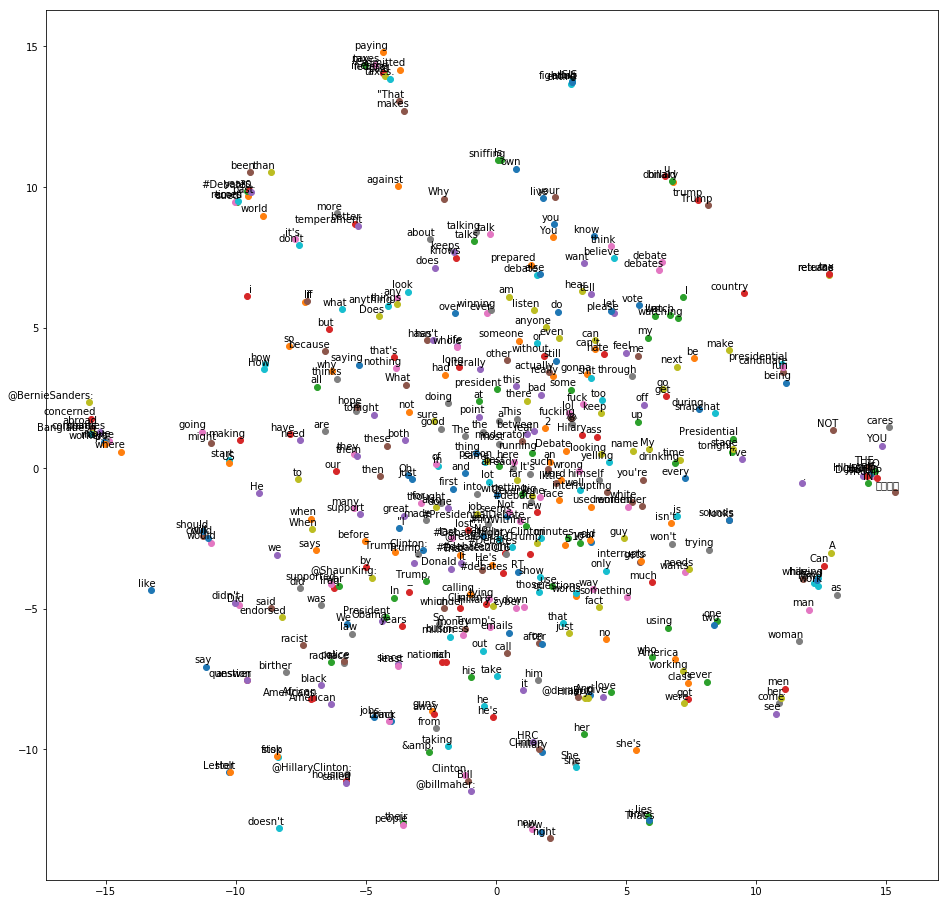

In [47]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


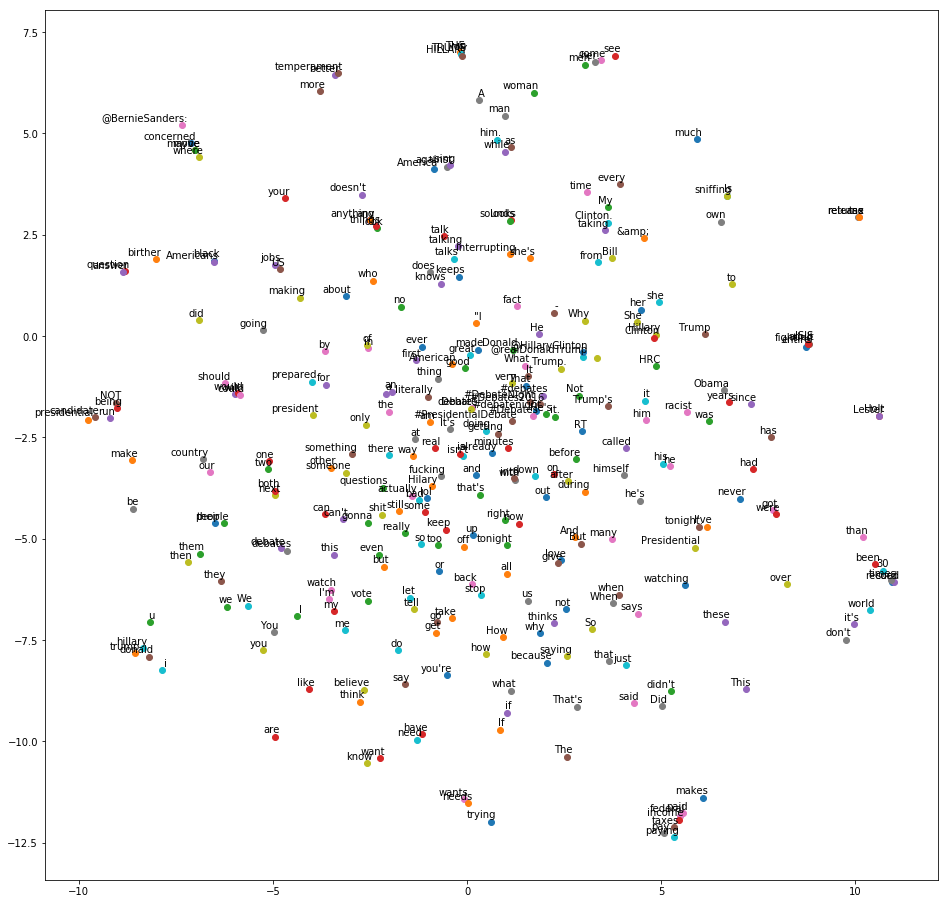

In [58]:
model = Word2Vec(corpus, size=100, window=20, min_count=300, workers=4)
tsne_plot(model)

In [53]:
model.most_similar('trump')

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hillary', 0.688890278339386),
 ('donald', 0.5601229667663574),
 ('i', 0.5423467755317688),
 ('Trump', 0.5029007196426392),
 ('because', 0.45128053426742554),
 ('really', 0.39713865518569946),
 ('what', 0.3836327791213989),
 ('him', 0.35268405079841614),
 ('why', 0.34180110692977905),
 ('but', 0.3408677577972412)]

In [54]:
model.most_similar('Trump')

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('trump', 0.5029007792472839),
 ('He', 0.4689404368400574),
 ('he', 0.43887072801589966),
 ('HRC', 0.3799934387207031),
 ('his', 0.35335466265678406),
 ('Hillary', 0.3447341322898865),
 ('Donald', 0.32906097173690796),
 ('taxes', 0.2976415157318115),
 ("Trump's", 0.2935594618320465),
 ('us', 0.2898124158382416)]

In [56]:
model.most_similar('Clinton')

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Hillary', 0.7042126059532166),
 ('her', 0.6485741138458252),
 ('HRC', 0.6461416482925415),
 ('she', 0.5515344738960266),
 ('Obama', 0.4875847399234772),
 ('ISIS', 0.46416357159614563),
 ('#Debates2016', 0.37978148460388184),
 ('#DebateNight', 0.3609420657157898),
 ("she's", 0.3234235644340515),
 ('Why', 0.32102102041244507)]

it's seems like I haven't cleaned the corpus properly, the stopwords function has been not set properly.

... I will go back to it asap 